# SBND MCS Angular Resolution

## 0. Setup

In [1]:
import sys,os,yaml
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yaml
from tqdm.notebook import tqdm

SOFTWARE_DIR = '/sdf/data/neutrino/software/spine' 
SBND_HELPERS_DIR = '/sdf/home/b/bearc/sbnd/helpers'

# Set software directory
sys.path.append(SOFTWARE_DIR)
sys.path.append(SBND_HELPERS_DIR)

#SPINE imports
from spine.driver import Driver
from spine.vis.out import Drawer
from spine.utils.globals import MUON_PID,MUON_MASS,PART_COL,COORD_COLS
from spine.math.decomposition import principal_components
from spine.utils.tracking import get_track_segments

#Helpers
import plotters

plt.style.use(f'{SBND_HELPERS_DIR}/sbnd.mplstyle')

skip_line = '\n' + '*'*50 + '\n'

%load_ext autoreload
%autoreload 2

Welcome to JupyROOT 6.26/16


In [2]:
DATA_DIR = '/sdf/data/neutrino/bearc/larcv/v10_06_00_02_rain_highE_muon/full'
PLOT_DIR = 'plots'

## 1. Load data

In [3]:
_cfg = """
io:
  loader:
    batch_size: 64
    shuffle: False
    num_workers: 4
    collate_fn: all
    dataset:
      name: LArCVDataset
      file_keys: DATA_PATH
      schema:
        input_data:
          parser: sparse3d
          #sparse_event: sparse3d_pcluster
          args:
            sparse_event_list:
              - sparse3d_reco
              - sparse3d_reco_chi2
              - sparse3d_reco_hit_charge0
              - sparse3d_reco_hit_charge1
              - sparse3d_reco_hit_charge2
              - sparse3d_reco_hit_key0
              - sparse3d_reco_hit_key1
              - sparse3d_reco_hit_key2
        seg_label:
          parser: sparse3d
          sparse_event: sparse3d_pcluster_semantics_ghost
        clust_label:
          parser: cluster3d
          cluster_event: cluster3d_pcluster
          particle_event: particle_corrected
          sparse_semantics_event: sparse3d_pcluster_semantics
          add_particle_info: true
          clean_data: true
        ppn_label:
          parser: particle_points
          particle_event: particle_corrected
          sparse_event: sparse3d_pcluster
        meta:
          parser: meta
          sparse_event: sparse3d_pcluster
        run_info:
          parser: run_info
          sparse_event: sparse3d_pcluster
        particles:
          parser: particle
          particle_event: particle_corrected
          neutrino_event: neutrino_mpv
          cluster_event: cluster3d_pcluster
        sed:
          parser: cluster3d
          args: {cluster_event: cluster3d_sed, add_particle_info: false, clean_data: false}
        # crt_hits:
        #   parser: crthit
        #   crthit_event: crthit_crthit
"""

In [4]:
DATA_PATH = os.path.join(DATA_DIR, 'larcv_*.root')
cfg = yaml.safe_load(_cfg.replace('DATA_PATH', DATA_PATH))
driver = Driver(cfg)


 ██████████   ██████████    ███   ███       ██   ███████████
███        █  ██       ███   █    █████     ██   ██         
  ████████    ██       ███  ███   ██  ████  ██   ██████████ 
█        ███  ██████████     █    ██     █████   ██         
 ██████████   ██            ███   ██       ███   ███████████

Release version: 0.5.0

$CUDA_VISIBLE_DEVICES=None

Configuration processed at: Linux sdfturing014 4.18.0-372.32.1.el8_6.x86_64 #1 SMP Fri Oct 7 12:35:10 EDT 2022 x86_64 x86_64 x86_64 GNU/Linux

base: {world_size: 0, seed: 1751045174}
io:
  loader:
    batch_size: 64
    shuffle: false
    num_workers: 4
    collate_fn: all
    dataset:
      name: LArCVDataset
      file_keys: /sdf/data/neutrino/bearc/larcv/v10_06_00_02_rain_highE_muon/full/larcv_*.root
      schema:
        input_data:
          parser: sparse3d
          args:
            sparse_event_list: [sparse3d_reco, sparse3d_reco_chi2, sparse3d_reco_hit_charge0,
              sparse3d_reco_hit_charge1, sparse3d_reco_hit_char

### 1.1 Single event

In [19]:
entry = 0
driver.apply_filter(entry_list=[entry])
data = driver.process()
for k, v in data.items():
    data[k] = v[0]
meta = data['meta']

Total number of entries selected: 1



In [20]:
data.keys()

dict_keys(['index', 'file_index', 'file_entry_index', 'input_data', 'seg_label', 'clust_label', 'ppn_label', 'meta', 'run_info', 'particles', 'sed'])

In [21]:
voxels = meta.to_cm(data['clust_label'][:, COORD_COLS])

In [22]:
for p in data['particles']:
    if abs(p.pdg_code) == 13  and p.id < 5:
        print(p.id, p.pdg_code, p.energy_init-MUON_MASS)
        mask = data['clust_label'][:, PART_COL] == p.id
        track_dir = principal_components(voxels[mask])[0]
        print(track_dir)
        print(np.array(p.first_step), voxels[mask][0])
        clusts, dirs, _ = get_track_segments(voxels[mask], segment_length=5, method='bin_pca', min_count=30)
        print([len(c) for c in clusts])
        angles = np.dot(dirs, track_dir)
        print(angles)
        print(np.arccos(angles)*180/np.pi)

0 -13 100000.00001392461
[ 0.9805907  -0.09450026  0.17178938]
[ 425.5    1537.4999  205.5   ] [-179.40001    153.6          4.1000023]
[19, 13, 14, 21, 13, 15, 5, 10, 25, 21, 13, 14, 11, 9, 16, 13, 16, 30, 12, 23, 15, 15, 20, 21, 14, 29, 37, 20, 23, 30, 39, 26, 24, 35, 34, 29, 22, 28, 30, 18, 40, 41, 22, 27, 23, 15, 33, 35, 14, 19, 16, 24, 18, 25, 21, 22, 24, 19, 23, 29, 24, 8, 14, 19, 21, 14, 24, 10, 8, 12, 22, 9, 14, 15, 19, 22, 12, 11]
[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         0.9936101  1.         1.         1.
 0.99715257 1.         1.         0.9991269  0.99897295 1.
 1.         1.         1.         1.         0.997952   0.99972
 1.         1.         1.         1.         0.99674207 0.99925095
 1.         1.         1.         1.         1.         1.
 1.         

## 2. More stats

In [5]:
from collections import defaultdict

In [22]:
all_angles = defaultdict(list)
seg_lengths = np.arange(2,25)
driver.apply_filter()
#for i in tqdm(range(100)): # CHANGE STATS HERE!
for i in tqdm(range(9840)):
    # Load a specific event
    #print(i)
    data = driver.process()
    for key, value in data.items():
        #if isinstance(value, list):
        data[key] = value[0]

    # If requested, convert to detector coordinates
    detector_coords = True
    data['clust_label'][:, COORD_COLS] = data['meta'].to_cm(data['clust_label'][:, COORD_COLS])
    voxels = data['clust_label'][:, COORD_COLS]
    
    for p in data['particles']:
        if abs(p.pdg_code) == 13 and p.energy_init > 15000:
            #print(p.pdg_code, p.energy_init)
            mask = data['clust_label'][:, PART_COL] == p.id
            for sl in seg_lengths:
                #track_dir = principal_components(voxels[mask])[0]
                try:
                    clusts, dirs, lengths = get_track_segments(voxels[mask], segment_length=sl, method='bin_pca', min_count=10)
                except Exception as e:
                    print(e)
                    continue
                #angles = np.dot(dirs, track_dir)

                angles = np.sum(dirs[:-1] * dirs[1:], axis = 1)
                lengths = (lengths[:-1] + lengths[1:])/2        

                valid_mask = (angles < 1.-1e-6) & (np.abs((lengths-sl)/sl) < 0.1)

                all_angles[sl].extend(angles[valid_mask])

Total number of entries selected: 9840



  0%|          | 0/9840 [00:00<?, ?it/s]

StopIteration: 

Text(0.5, 0, '$\\arccos(\\hat{\\theta} \\cdot \\theta)$')

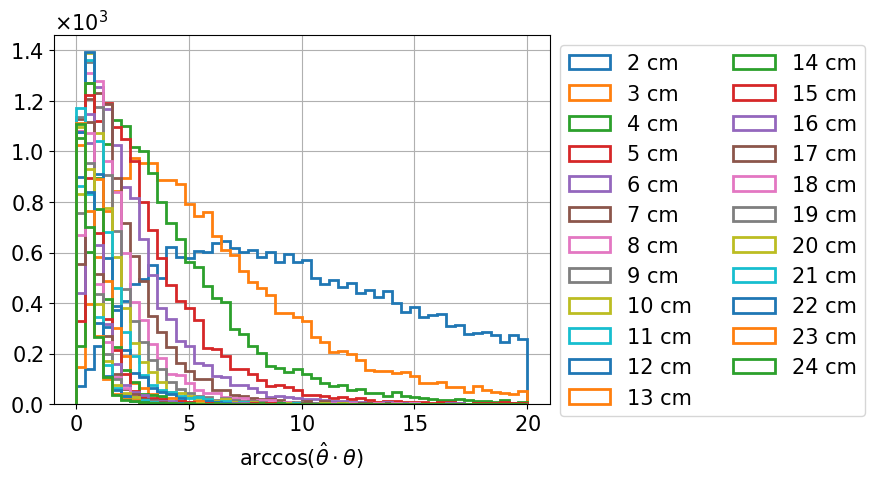

In [23]:
for sl in all_angles.keys():
    plt.hist(np.arccos(all_angles[sl])*180/np.pi, range=[0,20], bins=50, histtype='step', linewidth=2, label=f'{sl} cm')
plt.grid()
plt.legend(ncols=2,bbox_to_anchor=(1,1))
plt.xlabel(r'$\arccos(\hat{\theta} \cdot \theta)$')

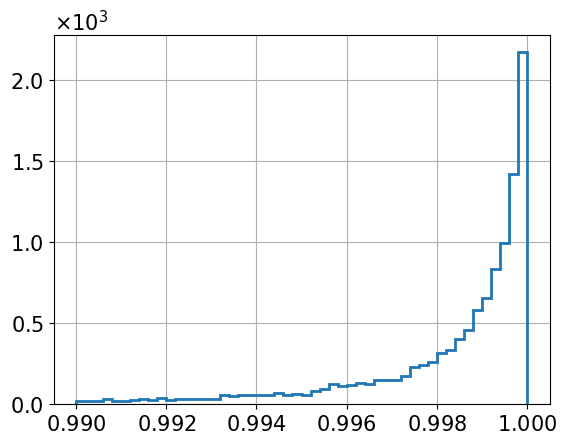

In [24]:
plt.hist(all_angles[5], range=[0.99,1.00], bins=50, histtype='step', linewidth=2)
plt.grid()

In [25]:
from spine.utils.mcs import split_angles

theta1, theta2 = defaultdict(list), defaultdict(list)
theta2d = {}
for sl in all_angles.keys():
    if not len(all_angles[sl]): continue
    theta1[sl], theta2[sl] = split_angles(np.arccos(all_angles[sl]))
    theta2d[sl] = np.concatenate([theta1[sl], theta2[sl]])

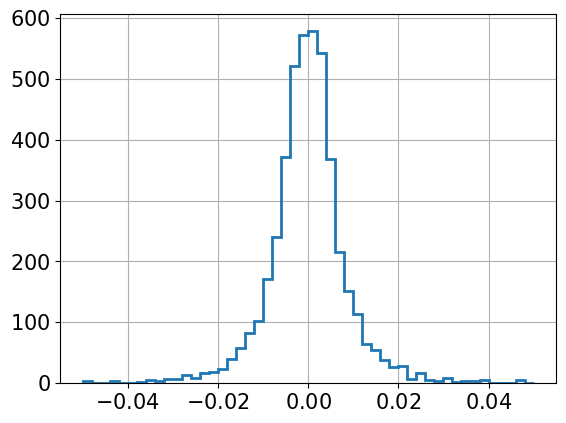

In [26]:
from matplotlib import pyplot as plt

plt.hist(theta2d[24], range=[-0.05,0.05], bins=50, histtype='step', linewidth=2)
plt.grid()

[0.3145823  1.19670647]
[-3.95439543e-03  4.75666459e-04  7.98547338e-04  6.20467751e-04
  9.56971117e-04  7.70092480e-04  5.27948847e-04  3.56310546e-04
  4.52214173e-05  7.41042589e-05  4.68464926e-04  2.90167939e-04
  1.98159645e-04  4.08773607e-06 -4.31774993e-07 -2.07444643e-04
 -3.35256719e-04 -3.95585260e-04 -3.33649369e-04 -4.84295455e-04
 -4.46730042e-04 -5.73513623e-04]


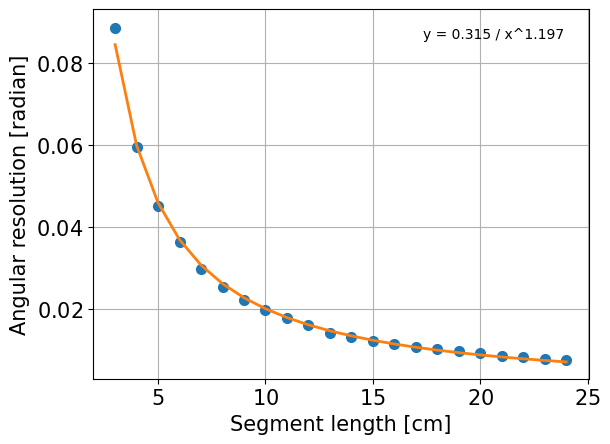

In [37]:
from scipy.optimize import curve_fit
from scipy.stats.mstats import trimmed_std

x = list(theta2d.keys())
skip = 1
x = x[skip:]
# y = [v.std() for k, v in theta2d.items()][skip:]
# yerr = [v.std()*np.sqrt(2)/np.sqrt(len(v)) for k, v in theta2d.items()][skip:]
y = [trimmed_std(v, limits=[0.01, 0.01]) for k, v in theta2d.items()][skip:]
yerr = [trimmed_std(v, limits=[0.01, 0.01])*np.sqrt(2)/np.sqrt(len(v)) for k, v in theta2d.items()][skip:]

fitfunc = lambda x, a, b: a/x**b
# fitfunc = lambda x, a, b: a/x**2 + b/x 
# fitfunc = lambda x, a, b, c: a/x**2 + b/x +c
# fitfunc = lambda x, a, b: a*np.exp(-x/b)

par, err = curve_fit(fitfunc, x, y, sigma=yerr)
print(par)

yfunc = fitfunc(np.array(x), *par)
#yfunc = fitfunc(np.array(x), 0.25, 1.25)

print(yfunc-y)

fig, ax = plt.subplots()
ax.errorbar(x, y, yerr=yerr, fmt='o',markersize=7)
ax.errorbar(x, yfunc, fmt='-')
ax.set_xlabel('Segment length [cm]')
ax.set_ylabel('Angular resolution [radian]')
ax.text(0.95, 0.95, f'y = {par[0]:.3f} / x^{par[1]:.3f}', transform=ax.transAxes, ha='right', va='top')
#ax.text(0.95, 0.90, f'N = {np.sum([len(v) for v in theta2d.values()])}', transform=ax.transAxes, ha='right', va='top')
ax.grid()

plotters.save_plot('mcs_fit',folder_name=PLOT_DIR)